In [1]:
from snake import SnakeGame
from agent import A2CAgent
import numpy as np
import torch

agent = A2CAgent.load("./agent_10x10.state")
rewards = np.array(torch.load("./rewards_10x10.state"))
agent

/Users/maurits/micromamba/envs/develop/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Agent loaded from ./agent_10x10.state


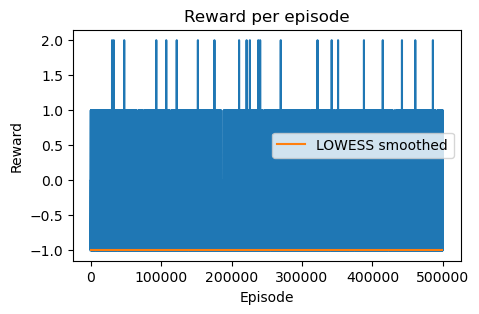

In [2]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt


lowess = sm.nonparametric.lowess
sampled = np.random.choice(len(rewards), 1000)
z = lowess(rewards[sampled], sampled)

sns.lineplot(rewards)
sns.lineplot(x=z[:, 0], y=z[:, 1], label="LOWESS smoothed")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per episode")
plt.gcf().set_size_inches(5, 3)
plt.savefig("./rewards_episodes.svg")

In [3]:
np.random.seed(11)
torch.manual_seed(8)

env = SnakeGame(10, 10, max_steps = 3000)

state = env.reset()

done = False
while not done:
    action = agent.act(state)
    print(env.steps)
    print({0: "up", 1: "right", 2: "down", 3: "left"}[action])
    next_state, reward, done = env.step(action)

    state = next_state
    if done:
        print("DIED")
        break

    env.render()

0
down
************
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*.......#..*
*.0.....H..*
*..........*
*..........*
************

1
left
************
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*.0....H#..*
*..........*
*..........*
************

2
down
************
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*.0....#...*
*......H...*
*..........*
************

3
down
************
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*.0........*
*......#...*
*......H...*
************

4
up
************
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*.0........*
*......H...*
*......#...*
************

5
down
************
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*..........*
*.0........*
*......#...*
*......H...*
************

6
down
DIED


In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import imageio


def create_frame(env, state_value, action_probs, step, critic_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Game board visualization
    ax1.clear()
    ax1.set_xlim(0, env.width)
    ax1.set_ylim(0, env.height)
    ax1.set_aspect("equal")
    ax1.axis("off")

    # Draw border
    border = patches.Rectangle(
        (0, 0), env.width, env.height, linewidth=2, edgecolor="black", facecolor="none"
    )
    ax1.add_patch(border)

    # Draw snake
    for x, y in env.tail.queue:
        snake_part = patches.Rectangle((x, y), 1, 1, facecolor="green")
        ax1.add_patch(snake_part)

    # Draw snake head
    head_x, head_y = env.tail.queue[-1]
    head = patches.Rectangle((head_x, head_y), 1, 1, facecolor="darkgreen")
    ax1.add_patch(head)

    # Draw apple
    apple = patches.Circle(
        (env.apple_x + 0.5, env.apple_y + 0.5), 0.4, facecolor="indianred"
    )
    ax1.add_patch(apple)

    ax1.set_title(f"Step: {step}, Score: {env.get_score()}")

    # Critic value plot
    ax2.clear()
    ax2.plot(critic_values, color="blue")
    ax2.set_title("Critic Value over Time")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Critic Value")
    ax2.scatter(step, state_value, color="red", s=100, zorder=5)

    ax3.clear()
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis("off")

    cmap = LinearSegmentedColormap.from_list("", ["lightblue", "red"])

    # Draw action probability circles
    circle_radius = 0.15
    circle_positions = [
        (0.5, 0.8),
        (0.8, 0.5),
        (0.5, 0.2),
        (0.2, 0.5),
    ]  # up, right, down, left
    action_names = ["up", "right", "down", "left"]

    for (x, y), prob, name in zip(circle_positions, action_probs, action_names):
        color = cmap(prob)
        circle = patches.Circle(
            (x, y), circle_radius, facecolor=color, edgecolor="black"
        )
        ax3.add_patch(circle)
        ax3.text(
            x,
            y,
            f"{name}\n{prob:.2f}",
            ha="center",
            va="center",
            color="black" if prob < 0.5 else "white",
        )

    ax3.set_title("Action Probabilities")

    plt.tight_layout()

    # Convert plot to image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)
    return image


def generate_gif(env, agent, output_file, max_steps=500):
    state = env.reset()
    frames = []
    step = 0
    critic_values = []

    while step < max_steps:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        state_value, policy_dist = agent.model(state_tensor)
        state_value = state_value.item()
        action_probs = policy_dist.squeeze().detach().numpy()

        critic_values.append(state_value)

        action = agent.act(state)
        next_state, reward, done = env.step(action)

        frame = create_frame(env, state_value, action_probs, step, critic_values)
        frames.append(frame)

        if done:
            break

        state = next_state
        step += 1

    # Repeat the final frame 30 times (3 seconds at 10 fps)
    final_frame = frames[-1]
    frames.extend([final_frame] * 30)

    imageio.mimsave(output_file, frames, fps=10, loop=1000)
    print(f"GIF saved to {output_file}")


agent = A2CAgent.load("./agent_10x10.state")

np.random.seed(11)
torch.manual_seed(8)
env = SnakeGame(10, 10, max_steps=3000)

# Generate and save the GIF
generate_gif(env, agent, "snake_game_visualisation.gif", max_steps=500)

Agent loaded from ./agent_10x10.state


/var/folders/3b/p0qfxjvs45l8nq2rnktrrymc0000gn/T/ipykernel_69587/4055856446.py:87: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")


GIF saved to snake_game_visualisation.gif
